# Titanic

In this notebook we are trying to predict who will survive the Titanic boat disaster. We will predict based on features like age, sex, passenger class or family size. We are using machine learning models to make these predictions. The predictions on the test set have 86.1% accuracy based on this machine learning model. The most important features are: passenger class, sex and survival rate of people with the same surname.   

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import scipy
import math

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

# Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier

# Settings
pd.options.display.max_rows = 20
pd.options.display.max_columns = 40
pd.options.display.float_format = '{:.3f}'.format
from IPython.display import display, HTML
import warnings
warnings.filterwarnings("ignore")

# Helper function
def plot(features):
    d={}
    for f in features:
        temp=df.groupby(["Survived",f]).size()
        d[f]=pd.concat([temp[0],temp[1]],axis=1).fillna(0)
    for f in features:
        plt.bar(np.arange(len(d[f][1])),d[f][1],bottom=d[f][0],label="Survived",color="g")
        plt.bar(np.arange(len(d[f][0])),d[f][0],label="Not survived",color="r")
        plt.xticks(np.arange(len(d[f][0])),d[f].index.values,rotation=90)
        plt.ylabel("Number of people")
        plt.title(f)
        plt.legend()
        plt.show() 

### Loading and check data

In [28]:
# Importing the datasets
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
trainId = train["PassengerId"]
testId = test["PassengerId"]
df = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [29]:
df.head(20)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.000,NaN,S,7.250,"Braund, Mr. Owen Harris",0,1,3,male,1,0.000,A/5 21171
1,38.000,C85,C,71.283,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.000,PC 17599
2,26.000,NaN,S,7.925,"Heikkinen, Miss. Laina",0,3,3,female,0,1.000,STON/O2. 3101282
3,35.000,C123,S,53.100,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.000,113803
4,35.000,NaN,S,8.050,"Allen, Mr. William Henry",0,5,3,male,0,0.000,373450
5,nan,NaN,Q,8.458,"Moran, Mr. James",0,6,3,male,0,0.000,330877
6,54.000,E46,S,51.862,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.000,17463
7,2.000,NaN,S,21.075,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.000,349909
8,27.000,NaN,S,11.133,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,female,0,1.000,347742
9,14.000,NaN,C,30.071,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,female,1,1.000,237736


In [30]:
df.tail()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1304,nan,NaN,S,8.050,"Spector, Mr. Woolf",0,1305,3,male,0,nan,A.5. 3236
1305,39.000,C105,C,108.900,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,nan,PC 17758
1306,38.500,NaN,S,7.250,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,nan,SOTON/O.Q. 3101262
1307,nan,NaN,S,8.050,"Ware, Mr. Frederick",0,1308,3,male,0,nan,359309
1308,nan,NaN,C,22.358,"Peter, Master. Michael J",1,1309,3,male,1,nan,2668


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [32]:
df.describe()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,1046.000,1308.000,1309.000,1309.000,1309.000,1309.000,891.000
mean,29.881,33.295,0.385,655.000,2.295,0.499,0.384
std,14.413,51.759,0.866,378.020,0.838,1.042,0.487
min,0.170,0.000,0.000,1.000,1.000,0.000,0.000
25%,21.000,7.896,0.000,328.000,2.000,0.000,0.000
50%,28.000,14.454,0.000,655.000,3.000,0.000,0.000
75%,39.000,31.275,0.000,982.000,3.000,1.000,1.000
max,80.000,512.329,9.000,1309.000,3.000,8.000,1.000


In [33]:
df.describe(include=['O'])

,Cabin,Embarked,Name,Sex,Ticket
count,295,1307,1309,1309,1309
unique,186,3,1307,2,929
top,C23 C25 C27,S,"Connolly, Miss. Kate",male,CA. 2343
freq,6,914,2,843,11


In [34]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000,891.000,891.000,714.000,891.000,891.000,891.000
mean,446.000,0.384,2.309,29.699,0.523,0.382,32.204
std,257.354,0.487,0.836,14.526,1.103,0.806,49.693
min,1.000,0.000,1.000,0.420,0.000,0.000,0.000
25%,223.500,0.000,2.000,20.125,0.000,0.000,7.910
50%,446.000,0.000,3.000,28.000,0.000,0.000,14.454
75%,668.500,1.000,3.000,38.000,1.000,0.000,31.000
max,891.000,1.000,3.000,80.000,8.000,6.000,512.329


In [35]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000,418.000,332.000,418.000,418.000,417.000
mean,1100.500,2.266,30.273,0.447,0.392,35.627
std,120.810,0.842,14.181,0.897,0.981,55.908
min,892.000,1.000,0.170,0.000,0.000,0.000
25%,996.250,1.000,21.000,0.000,0.000,7.896
50%,1100.500,3.000,27.000,0.000,0.000,14.454
75%,1204.750,3.000,39.000,1.000,0.000,31.500
max,1309.000,3.000,76.000,8.000,9.000,512.329


In [36]:
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"de Messemaeker, Mrs. Guillaume Joseph (Emma)",male,1601,G6,S
freq,1,577,7,4,644


In [37]:
test.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,418,418,418,91,418
unique,418,2,363,76,3
top,"Linehan, Mr. Michael",male,PC 17608,B57 B59 B63 B66,S
freq,1,266,5,3,270


There are 891 cases in the training set from which we know whether they survived and 418 cases in the test set and for them we are going to make predictions. 

### Feature analysis

In [38]:
df["Sex"]=df["Sex"].map({"male":1,"female":0,1:1,0:0}).values

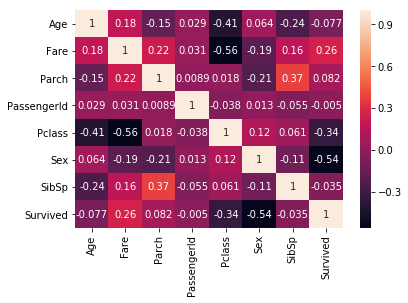

In [39]:
sns.heatmap(df.corr(),annot=True);
plt.show()

In [40]:
temp=df.groupby("Survived").size()
temp

Survived
0.000    549
1.000    342
dtype: int64

In [41]:
'{:.2f}'.format(temp[1]/float(temp[0]+temp[1]))

'0.38'

In the training set 38% of passengers survived. 

#### Sex

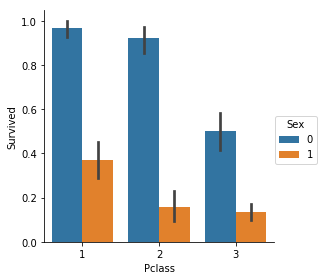

In [42]:
sns.factorplot(x="Pclass",y="Survived",hue="Sex",data=df,kind="bar");
plt.show()

In [43]:
df["PSex"]=2*df["Pclass"]-1+df["Sex"]

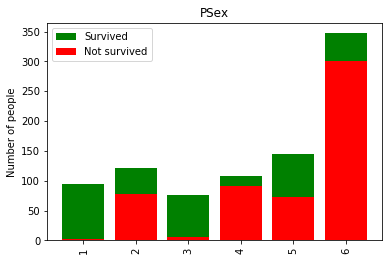

In [44]:
plot(["PSex"])

#### Pclass

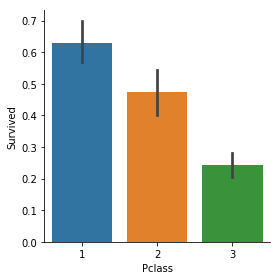

In [45]:
sns.factorplot(x="Pclass",y="Survived",data=df,kind="bar")
plt.show()

#### Fare

In [46]:
df["Fare"]=df["Fare"].fillna(df["Fare"].median())

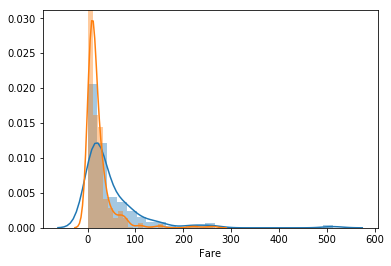

In [47]:
sns.distplot(df["Fare"][df["Survived"]==1],bins=25)
sns.distplot(df["Fare"][df["Survived"]==0],bins=25)
plt.show()

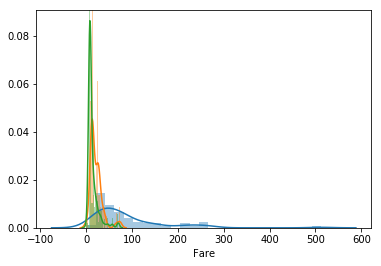

In [48]:
sns.distplot(df["Fare"][df["Pclass"]==1],bins=25)
sns.distplot(df["Fare"][df["Pclass"]==2],bins=25)
sns.distplot(df["Fare"][df["Pclass"]==3],bins=25)
plt.show()

In [49]:
df["LFare"]=df["Fare"].apply(lambda x: math.log(x+1))

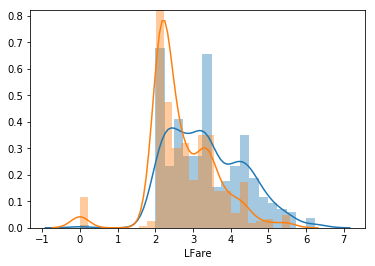

In [50]:
sns.distplot(df["LFare"][df["Survived"]==1],bins=25)
sns.distplot(df["LFare"][df["Survived"]==0],bins=25)
plt.show()

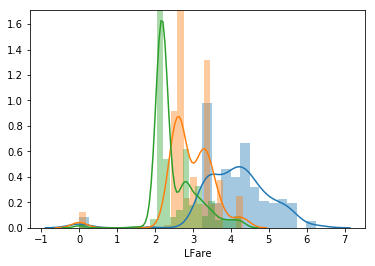

In [51]:
sns.distplot(df["LFare"][df["Pclass"]==1],bins=25)
sns.distplot(df["LFare"][df["Pclass"]==2],bins=25)
sns.distplot(df["LFare"][df["Pclass"]==3],bins=25)

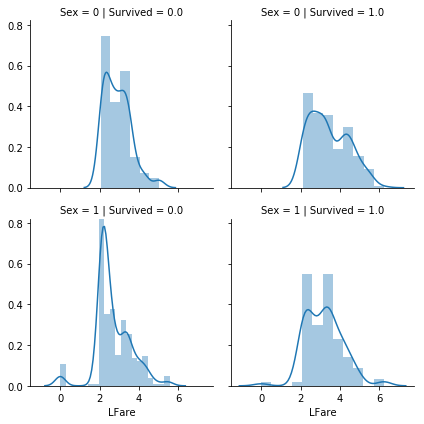

In [52]:
sns.FacetGrid(df,row="Sex",col="Survived").map(sns.distplot,"LFare")

In [53]:
df["rLFare"]=pd.cut(df["LFare"],[0,3,4,5,8],labels=[1,2,3,4])

In [54]:
pd.crosstab(df["Survived"],df["rLFare"])

rLFare,1,2,3,4
Survived,,,,
0.000,356,34,136,9
1.000,136,78,107,20


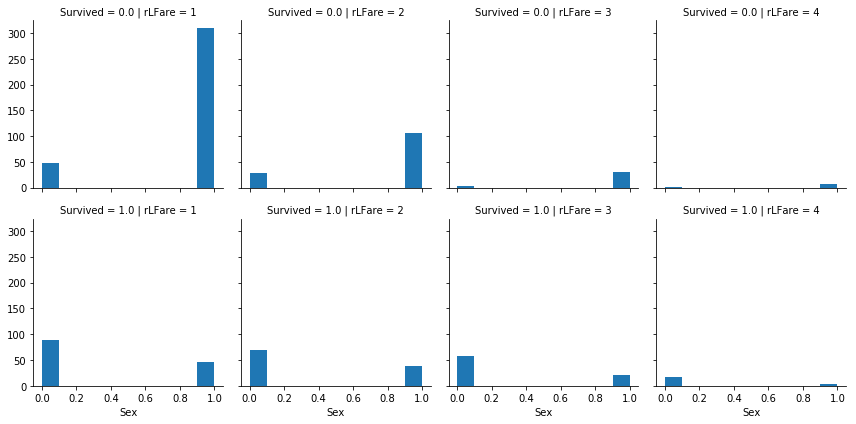

In [55]:
sns.FacetGrid(df,col="rLFare",row="Survived").map(plt.hist,"Sex")

#### Age

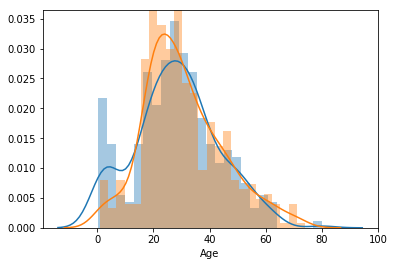

In [56]:
sns.distplot(df["Age"][(df["Age"].notnull())&(df["Survived"]==1)],bins=25)
sns.distplot(df["Age"][(df["Age"].notnull())&(df["Survived"]==0)],bins=25)

In [57]:
df["Age"].describe()

count   1046.000
mean      29.881
std       14.413
min        0.170
25%       21.000
50%       28.000
75%       39.000
max       80.000
Name: Age, dtype: float64

In [58]:
df["AgeGroup"]=pd.cut(df["Age"],[0,5,15,20,25,60,85],labels=[1,2,3,4,5,6])

In [59]:
pd.crosstab(df.Survived,df.AgeGroup)

AgeGroup,nan,1.0,2.0,3.0,4.0,5.0
Survived,,,,,,
0.000,63,80,230,17,13,21
1.000,33,42,161,5,31,18


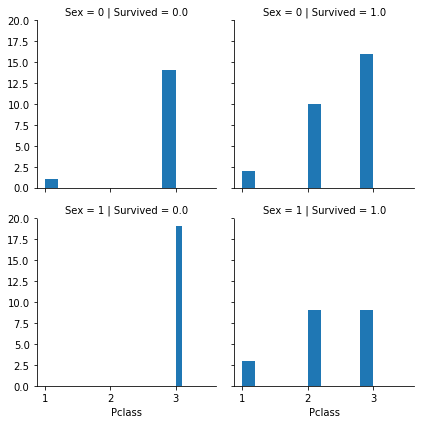

In [60]:
sns.FacetGrid(df[(df["AgeGroup"]==1)|(df["AgeGroup"]==2)],col="Survived",row="Sex").map(plt.hist,"Pclass")

In [61]:
def agepclass(id):
    if ((df.loc[id,"Pclass"]==1)|(df.loc[id,"Pclass"]==2))&(df.loc[id,"Age"]<15):
        return 1
    else:
        return 0

In [62]:
df["agepclass"]=pd.Series(range(0,1309)).apply(agepclass)

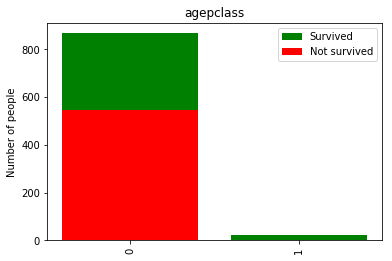

In [63]:
plot(["agepclass"])

#### Embarked

In [64]:
df.groupby("Embarked").size()

Embarked
C    270
Q    123
S    914
dtype: int64

In [65]:
df["Embarked"]=df["Embarked"].fillna(df["Embarked"].mode()[0])

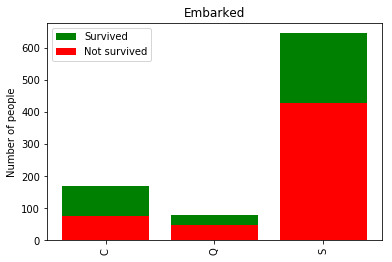

In [66]:
plot(["Embarked"])

#### SibSp

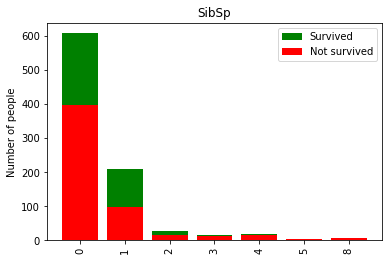

In [67]:
plot(["SibSp"])

#### Parch

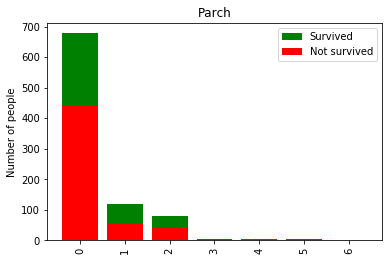

In [68]:
plot(["Parch"])

### Filling missing values

#### Age

In [69]:
df[df["Age"].isnull()].shape[0]

263

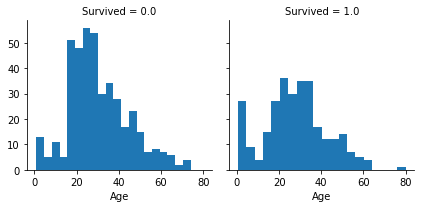

In [70]:
g=sns.FacetGrid(df[df["Age"].notnull()],col="Survived").map(plt.hist,"Age",bins=20)

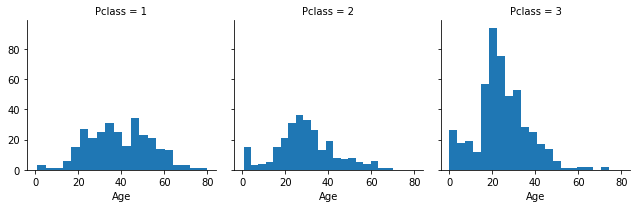

In [71]:
g=sns.FacetGrid(df[df["Age"].notnull()],col="Pclass").map(plt.hist,"Age",bins=20)

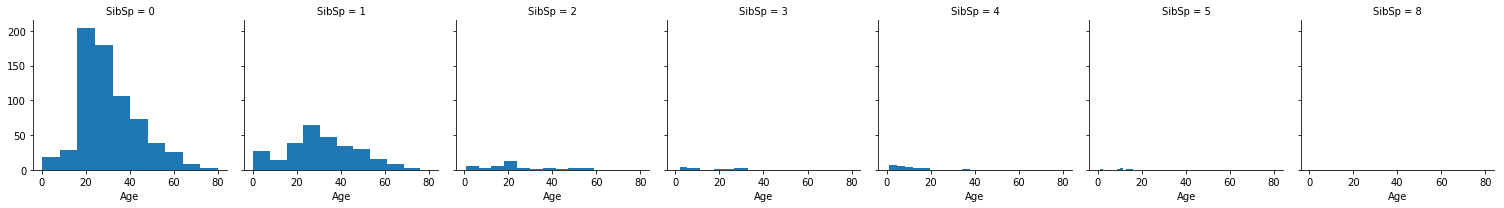

In [72]:
g=sns.FacetGrid(df[df["Age"].notnull()],col="SibSp").map(plt.hist,"Age")

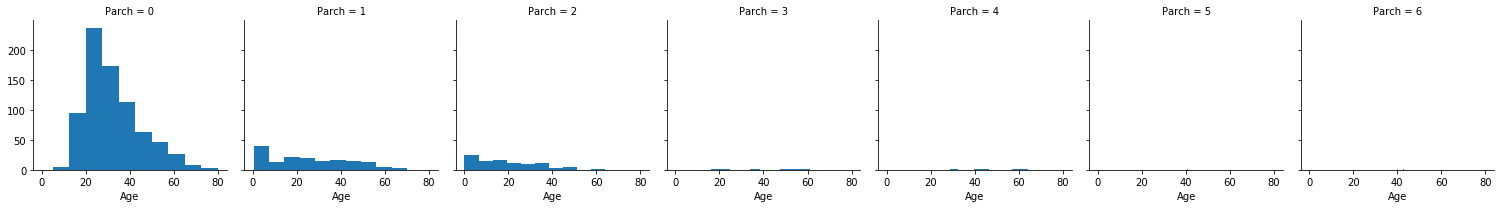

In [73]:
g=sns.FacetGrid(df[df["Age"].notnull()],col="Parch").map(plt.hist,"Age")

In [74]:
index_age=df[df["Age"].isnull()].index.values  

In [75]:
def restore_age():
    df.loc[index_age,"Age"]=float("nan")

In [76]:
def fill_age_1():
    median=df["Age"][df["Age"].notnull()].median()
    for i in index_age: 
        Pclass,Parch,SibSp=df.loc[i,"Pclass"],df.loc[i,"Parch"],df.loc[i,"SibSp"]
        subset=df["Age"][(df["Pclass"]==Pclass)&(df["Parch"]==Parch)&(df["SibSp"]==SibSp)]
        if subset.any():
            median_s=int(subset.median())
            df.loc[i,"Age"]=median_s
        else:
            df.loc[i,"Age"]=median 

In [77]:
fill_age_1()

This values we filled: 

(array([  4.,   0.,  12.,   5.,   0., 180.,   7.,  16.,   0.,  39.]),
 array([ 6. ,  9.3, 12.6, 15.9, 19.2, 22.5, 25.8, 29.1, 32.4, 35.7, 39. ]),
 <a list of 10 Patch objects>)

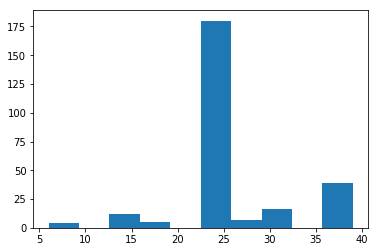

In [78]:
plt.hist(df.loc[index_age,"Age"])

(array([ 39.,   0.,   0.,   0.,   0.,  16.,   0.,   0.,   0., 208.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <a list of 10 Patch objects>)

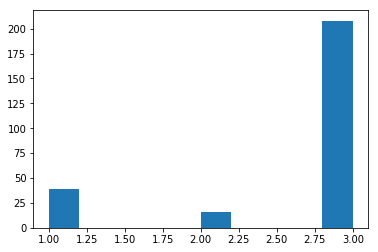

In [79]:
plt.hist(df.loc[index_age,"Pclass"])

### Feature engineering

#### Deck

In [80]:
def find_deck(cabin):
    try:
        match=re.search(r'[A-Z]',str(cabin))
        return match.group()
    except AttributeError:
        return 0

In [81]:
df["Deck"]=df["Cabin"].apply(find_deck)   

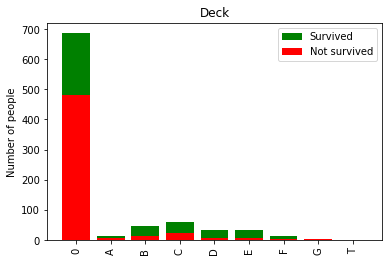

In [82]:
plot(["Deck"])

#### DeckKnown

In [83]:
df["DeckKnown"]=df["Deck"].apply(lambda x: 1 if x else 0)

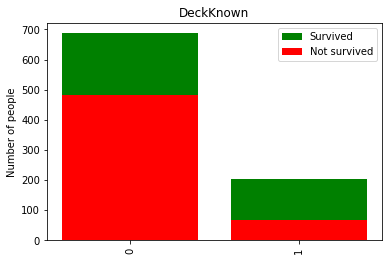

In [84]:
plot(["DeckKnown"])

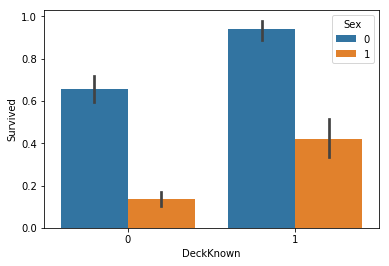

In [85]:
sns.barplot(x="DeckKnown",y="Survived",hue="Sex",data=df)

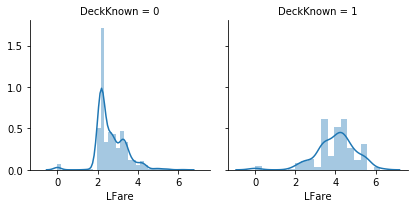

In [86]:
sns.FacetGrid(col="DeckKnown",data=df).map(sns.distplot,"LFare")

#### Survivors on same ticket

In [87]:
def survivors_ticket(index):
    ticketnr=df.loc[index,"Ticket"]
    temp=df[df["Ticket"]==ticketnr]
    if index<=890:
        survived=temp["Survived"].sum()-df.loc[index,"Survived"]
    else:
        survived=temp["Survived"].sum()
    return survived

In [88]:
df["SurvivorsTicket"]=pd.Series(df.index).apply(survivors_ticket)

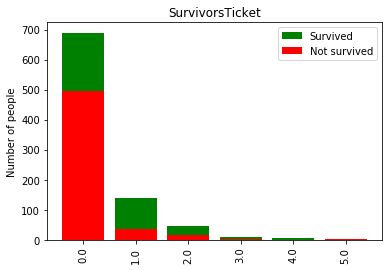

In [89]:
plot(["SurvivorsTicket"])

In [90]:
df["Stick2"]=df["SurvivorsTicket"].apply(lambda x: round(x/(x+1)))

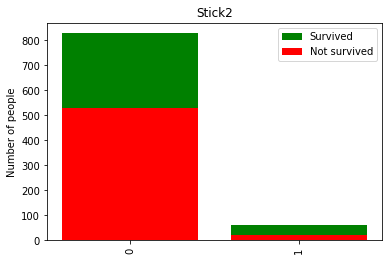

In [91]:
plot(["Stick2"])

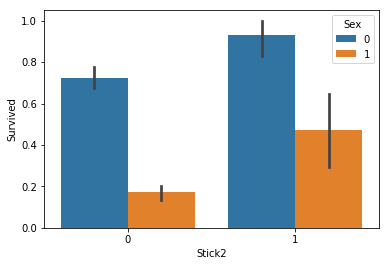

In [92]:
sns.barplot(x="Stick2",y="Survived",hue="Sex",data=df)

#### Title

In [93]:
def find_title(name):
    match=re.search(r",\s[A-Za-z]+",str(name))
    return match.group()[2:]

In [94]:
df["Title"]=df["Name"].apply(find_title)
df["Title"]=df["Title"].replace(["Capt","Col","Don","Dr","Jonkheer","Lady","Major",
                                 "Mlle","Mme","Ms","Rev","Sir","the","Dona"],"rare")

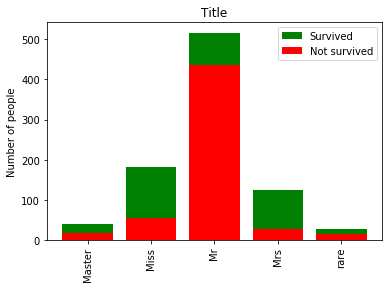

In [95]:
plot(["Title"])

(array([18., 10.,  8., 10.,  4.,  6.,  4.,  0.,  0.,  1.]),
 array([ 0.33 ,  2.797,  5.264,  7.731, 10.198, 12.665, 15.132, 17.599,
        20.066, 22.533, 25.   ]),
 <a list of 10 Patch objects>)

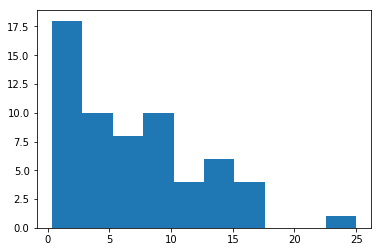

In [96]:
plt.hist(df[df["Title"]=="Master"]["Age"])

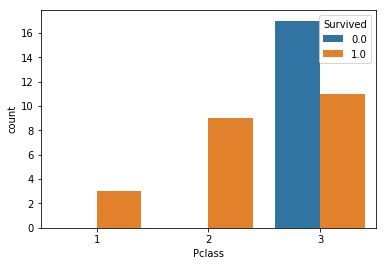

In [97]:
sns.countplot(x="Pclass",hue="Survived",data=df[df["Title"]=="Master"])

In [98]:
df[(df["Title"]=="Master")&(df["Survived"].isnull())].shape[0]

21

#### Family Size

In [99]:
df["Size"]=df["SibSp"]+df["Parch"]

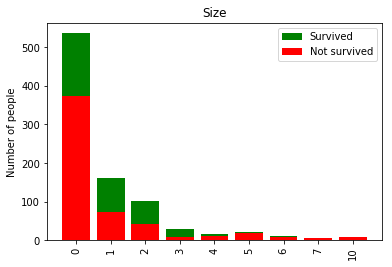

In [100]:
plot(["Size"])

In [101]:
def family_size(size):
    if size==0:
        return "Single"
    if (size>=1) & (size<=3):
        return "Small"
    if size>=4:
        return "Large"

In [102]:
df["FSize"]=df["Size"].apply(family_size)

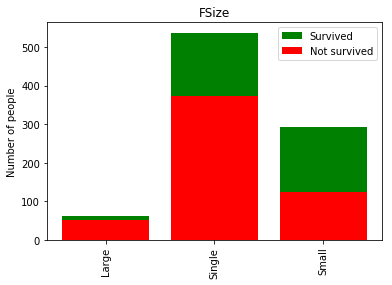

In [103]:
plot(["FSize"])

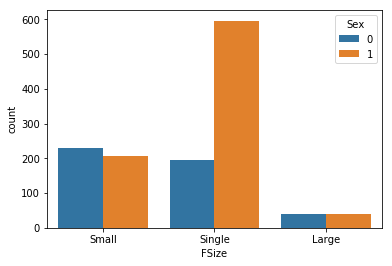

In [104]:
sns.countplot(x="FSize",hue="Sex",data=df)

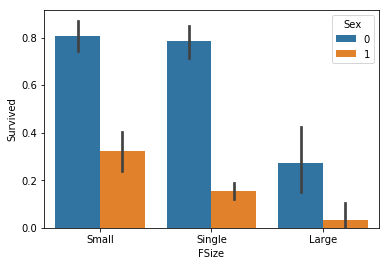

In [105]:
sns.barplot(x="FSize",y="Survived",hue="Sex",data=df)

#### Groupings

In [106]:
def find_surname(name):
    match=re.search(r"[A-Za-z]+,",str(name))
    return match.group()[:-1]
df["Surname"]=df["Name"].apply(find_surname)
df["Surname"][(df["Sex"]==1)&(df["Title"]!="Master")]="NoGroup"

In [107]:
def surname_freq(surname):
    return df.groupby("Surname").size().loc[str(surname)]  
df["Surname_freq"]=df["Surname"].apply(surname_freq)
df["Surname"][df["Surname_freq"]<=1]="NoGroup"

In [108]:
def survival_rate(surname):
    if surname == "NoGroup":
        return 0.5
    else:
        return df.groupby("Surname").mean()["Survived"].loc[surname]
df["SurvivalRate"]=df["Surname"].apply(survival_rate)

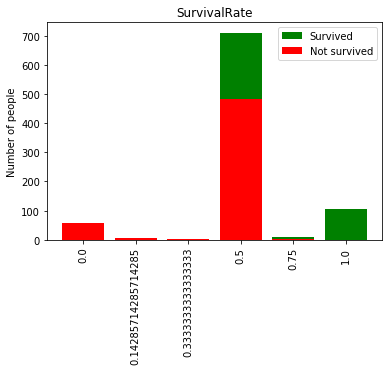

In [109]:
plot(["SurvivalRate"])

In [110]:
df.groupby("SurvivalRate").size()

SurvivalRate
0.000      71
0.143       8
0.333       3
0.500    1044
0.750      10
1.000     158
dtype: int64

In [111]:
print( sorted(df[df["SurvivalRate"]==1].Surname.unique()))

['Abbott', 'Aks', 'Baclini', 'Becker', 'Bonnell', 'Brown', 'Burns', 'Caldwell', 'Carr', 'Christy', 'Collyer', 'Compton', 'Connolly', 'Coutts', 'Crosby', 'Davies', 'Dean', 'Dodge', 'Doling', 'Drew', 'Fleming', 'Fortune', 'Goldsmith', 'Graham', 'Hamalainen', 'Harper', 'Hart', 'Hays', 'Heilmann', 'Herman', 'Hippach', 'Hirvonen', 'Hocking', 'Johnson', 'Kelly', 'Laroche', 'Lines', 'Mallet', 'McCoy', 'McGowan', 'Mellinger', 'Minahan', 'Moor', 'More', 'Moubarek', 'Murphy', 'Nakid', 'Navratil', 'Newell', 'Nilsson', 'Peter', 'Phillips', 'Quick', 'Richards', 'Ryerson', 'Sandstrom', 'Smith', 'Spedden', 'Taussig', 'Thomas', 'Touma', 'Watt', 'Wells', 'West', 'Wick', 'Yarred']


In [112]:
print( sorted(df[df["SurvivalRate"]==0].Surname.unique()))

['Barbara', 'Boulos', 'Bourke', 'Cacic', 'Danbom', 'Ford', 'Goodwin', 'Ilmakangas', 'Impe', 'Johnston', 'Jussila', 'Lefebre', 'Oreskovic', 'Palsson', 'Panula', 'Planke', 'Rice', 'Rosblom', 'Sage', 'Skoog', 'Strom', 'Zabour']


In [113]:
df[df["SurvivalRate"]==1/7][["Title","SurvivalRate","Survived","Surname","Age","Pclass"]]

,Title,SurvivalRate,Survived,Surname,Age,Pclass
68,Miss,0.143,1.000,Andersson,17.000,3
119,Miss,0.143,0.000,Andersson,2.000,3
541,Miss,0.143,0.000,Andersson,9.000,3
542,Miss,0.143,0.000,Andersson,11.000,3
610,Mrs,0.143,0.000,Andersson,39.000,3
813,Miss,0.143,0.000,Andersson,6.000,3
850,Master,0.143,0.000,Andersson,4.000,3
1105,Miss,0.143,nan,Andersson,38.000,3


In [114]:
df[df["SurvivalRate"]==1/3][["Title","SurvivalRate","Survived","Surname","Age","Pclass"]]

,Title,SurvivalRate,Survived,Surname,Age,Pclass
297,Miss,0.333,0.000,Allison,2.000,1
305,Master,0.333,1.000,Allison,0.920,1
498,Mrs,0.333,0.000,Allison,25.000,1


In [115]:
df[df["SurvivalRate"]==3/4][["Title","SurvivalRate","Survived","Surname","Age","Pclass"]]

,Title,SurvivalRate,Survived,Surname,Age,Pclass
25,Mrs,0.750,1.000,Asplund,38.000,3
182,Master,0.750,0.000,Asplund,9.000,3
233,Miss,0.750,1.000,Asplund,5.000,3
261,Master,0.750,1.000,Asplund,3.000,3
435,Miss,0.750,1.000,Carter,14.000,1
763,Mrs,0.750,1.000,Carter,36.000,1
802,Master,0.750,1.000,Carter,11.000,1
854,Mrs,0.750,0.000,Carter,44.000,2
1045,Master,0.750,nan,Asplund,13.000,3
1270,Master,0.750,nan,Asplund,5.000,3


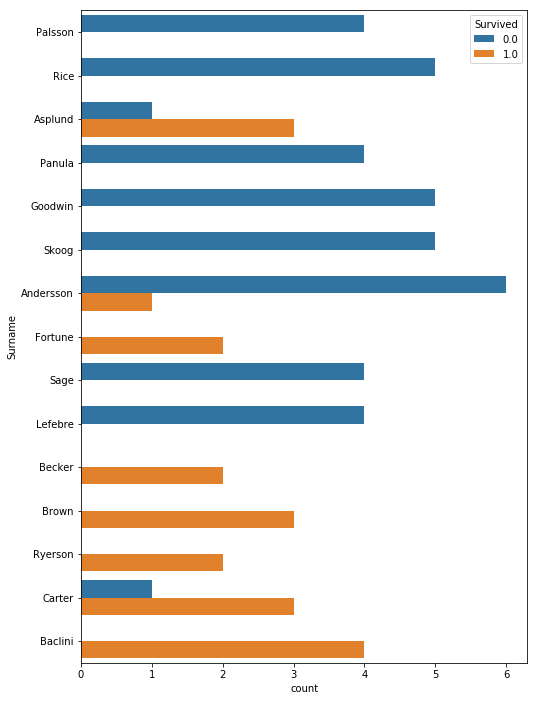

In [116]:
plt.figure(figsize=(8,12))
sns.countplot(y="Surname",hue="Survived",data=df[(df["Surname_freq"]>=4)&(df["Surname_freq"]<=20)],orient="v")

#### Correlation

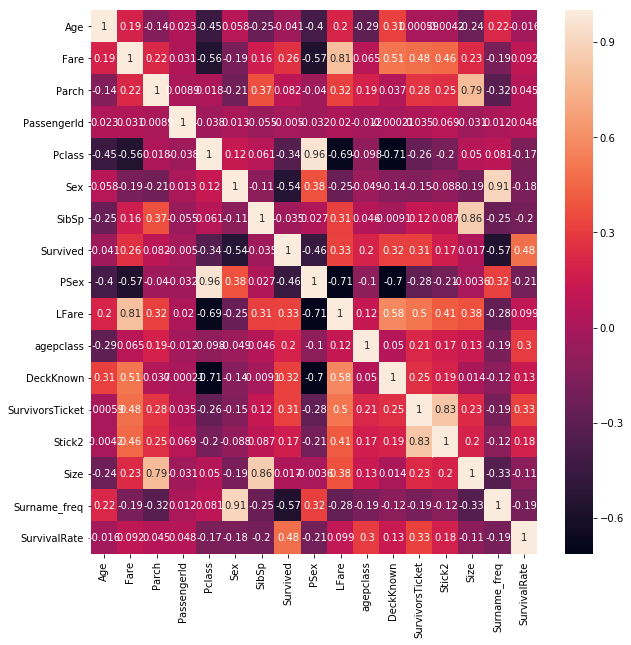

In [117]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),annot=True)

#### Get dummies

In [118]:
df_dummies=pd.get_dummies(df,columns=["PSex","Pclass","FSize","Title","AgeGroup","Embarked"])

In [119]:
df_dummies.head()

,Age,Cabin,Fare,Name,Parch,PassengerId,Sex,SibSp,Survived,Ticket,LFare,rLFare,agepclass,Deck,DeckKnown,SurvivorsTicket,Stick2,Size,Surname,Surname_freq,...,Pclass_1,Pclass_2,Pclass_3,FSize_Large,FSize_Single,FSize_Small,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_rare,AgeGroup_1,AgeGroup_2,AgeGroup_3,AgeGroup_4,AgeGroup_5,AgeGroup_6,Embarked_C,Embarked_Q,Embarked_S
0,22.000,NaN,7.250,"Braund, Mr. Owen Harris",0,1,1,1,0.000,A/5 21171,2.110,1,0,0,0,0.000,0,1,NoGroup,782,...,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1
1,38.000,C85,71.283,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,0,1,1.000,PC 17599,4.281,3,0,C,1,0.000,0,1,NoGroup,1,...,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0
2,26.000,NaN,7.925,"Heikkinen, Miss. Laina",0,3,0,0,1.000,STON/O2. 3101282,2.189,1,0,0,0,0.000,0,0,NoGroup,1,...,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
3,35.000,C123,53.100,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,0,1,1.000,113803,3.991,2,0,C,1,0.000,0,1,NoGroup,1,...,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1
4,35.000,NaN,8.050,"Allen, Mr. William Henry",0,5,1,0,0.000,373450,2.203,1,0,0,0,0.000,0,0,NoGroup,782,...,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1


### Machine learning

I split my data into 3 partitions. Training set, test set and real test set. I also use cross-validation on training set. 

In [120]:
X_full=df_dummies.drop(labels=["Survived"],axis=1)[:len(train)]
y_full=df_dummies["Survived"][:len(train)]
test=df_dummies.drop(labels=["Survived"],axis=1)[len(train):]

In [121]:
X_train,X_test,y_train,y_test=train_test_split(X_full,y_full,test_size=0.25,shuffle=True,random_state=42)

#### Cross-validation

In [122]:
clfs=[DecisionTreeClassifier(),SVC(),AdaBoostClassifier(),RandomForestClassifier(),KNeighborsClassifier(),GaussianNB(),
      XGBClassifier(),LogisticRegression(),
      VotingClassifier(estimators=[("xgb",XGBClassifier()),("svm",SVC()),("lr",LogisticRegression())
                                  ,("ada",AdaBoostClassifier()),("rf",RandomForestClassifier())])]

In [123]:
kfold=RepeatedStratifiedKFold(n_splits=5,n_repeats=1,random_state=42)

In [125]:
features = ["Sex"]

In [126]:
def cross_validate(X_train=X_train,y_train=y_train,clfs=clfs,features=features,kfold=kfold,vis=True,table=True):
    outcomes={}
    names=[]
    mean_accuracy=[]
    std=[]
    for c in clfs: 
        name=c.__class__.__name__
        names.append(name)
        outcomes[name]=cross_val_score(c,X_train[features],y_train,cv=kfold,scoring="accuracy",verbose=0)
        mean_accuracy.append(outcomes[name].mean())
        std.append(outcomes[name].std())
    clf_results=pd.DataFrame({"Classifier":names,"Mean accuracy":mean_accuracy,"Standard Deviation":std})
    print ("features:" + str(features))
    if table:
        display(clf_results)
    if vis:
        plt.bar(np.arange(len(clf_results)),clf_results["Mean accuracy"],yerr=clf_results["Standard Deviation"])
        plt.xticks(np.arange(len(clf_results)),clf_results["Classifier"],rotation=90)
        plt.show()      

For the best results we use the features psex and survivalrate. Psex is an engineered feature that predicts very well survival. It is based on the sex and the passenger class. Survivalrate is a feature that equals the survival rate of passengers with the same surname. 

features:['PSex_1', 'PSex_2', 'PSex_3', 'PSex_4', 'PSex_5', 'PSex_6', 'SurvivalRate']


,Classifier,Mean accuracy,Standard Deviation
0,DecisionTreeClassifier,0.862,0.034
1,SVC,0.852,0.035
2,AdaBoostClassifier,0.861,0.031
3,RandomForestClassifier,0.861,0.034
4,KNeighborsClassifier,0.859,0.033
5,GaussianNB,0.816,0.047
6,XGBClassifier,0.861,0.031
7,LogisticRegression,0.861,0.031
8,VotingClassifier,0.861,0.031


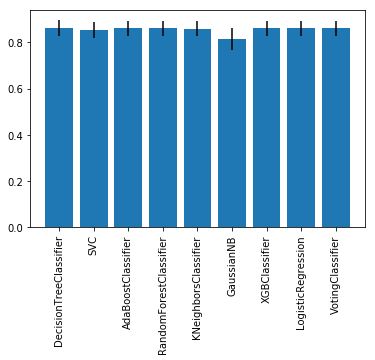

In [130]:
features=["PSex_1","PSex_2","PSex_3","PSex_4","PSex_5","PSex_6","SurvivalRate"]
cross_validate(features=features)

### Check on test set

In [131]:
xgb=XGBClassifier()
xgb.fit(X_train[features],y_train)
pred=xgb.predict(X_test[features])
accuracy_score(y_test,pred)

0.8609865470852018

### Parameter tuning

In [132]:
tuning_results={}

In [133]:
def do_tune(clf_single,parameters):
    clf=GridSearchCV(clf_single,parameters,cv=kfold,scoring="accuracy",verbose=1,n_jobs=-1)
    clf.fit(X_full[features],y_full)
    name=clf_single.__class__.__name__
    tuning_results[name]=[clf.best_score_,clf.best_params_,clf.best_estimator_]
    return

In [134]:
parameters_AB={"learning_rate":[0.1,0.2,0.4,1],"n_estimators":[50],"base_estimator":[DecisionTreeClassifier()],"algorithm":\
              ["SAMME","SAMME.R"]}
parameters_RF = {"max_depth": [None],"max_features": [1, 3, 10],"min_samples_split": [2, 3, 10],"min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],"n_estimators" :[100,300],"criterion": ["gini"]}
parameters_logr={"C":[0.001,0.01,0.1,1,10,100,1000]}
parameters_xgb={"max_depth":[3,5,6,7,9,11,13,17,20],"learning_rate":[0.001,0.01,0.1]}


In [135]:
do_tune(xgb,parameters_xgb)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   58.9s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  1.0min finished


In [136]:
results,keys,clf_best=[],[],[]
for k in tuning_results.keys():
    keys.append(k)
    results.append(tuning_results[k][0])   
    clf_best.append(tuning_results[k][2])

In [137]:
pd.DataFrame({"name":keys,"tuned accuracy":results})

,name,tuned accuracy
0,XGBClassifier,0.861


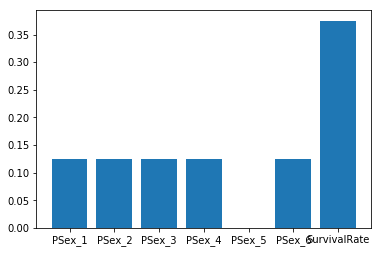

In [138]:
plt.figure()
plt.bar(np.arange(len(X_full[features].columns)),tuning_results["XGBClassifier"][2].feature_importances_)
plt.xticks(np.arange(len(X_full[features].columns)),X_full[features])
plt.show()

In [139]:
clf_best

[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=1, gamma=0, learning_rate=0.001, max_delta_step=0,
        max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
        n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
        silent=True, subsample=1)]

In [140]:
pred_xgb=clf_best[0].predict(test[features])

### Output

In [141]:
submission=pd.concat([testId,pd.Series(pred_xgb).astype(int)],axis=1)
submission.columns=["PassengerId","Survived"]
submission.to_csv("FourthSubmission.csv",index=False)
submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
